# Report: Pytorch DDPG Continuous Control
### Wendell Luckow - 12/18/18

In [1]:
#Import Dependencies
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import random
import math
import sys
from unityagents import UnityEnvironment
import numpy as np
import time
import pickle

import warnings
warnings.filterwarnings("ignore")

## The Environment

This project uses a single agent to attempt to solve the Unity Reacher environment. The agent takes 4 continuous actions at every timestep with values between -1 and 1. The environment includes 33 different features. Each episode (game) lasts for 1000 time steps. The agent is rewarded if the two-jointed arm is touching the moving target in 3-D space.

## Solve criteria

The environment is considered solved if the agent can get an average score of 30 over 100 consecutive games. 

In [2]:
#Initialize Unity Environment executable
env = UnityEnvironment(file_name='./Reacher_Windows_x86_64/Reacher.exe')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

#reset the environment
env_info = env.reset(train_mode=True)[brain_name]

#pull the action size 
action_size = brain.vector_action_space_size

#pull the state size
states = env_info.vector_observations
state_size = states.shape[1]

#define the number of agents
num_agents = 1

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Network Architectures

This agent utilizes DDPG (Deep Deterministic Policy Gradient) which is a Model-free off-policy continuous reinforcement learning agent. There are two separate networks. The first network, the Actor, takes the state in as input and outputs the action as a vector of size 4. The second network, the Critic, takes both a state s and an action a and returns a predicted final value for taking action a in state s.

The actor network has three hidden layers with 64 neurons each (input --> hidden layer 1 --> hidden layer 2 --> hidden layer 3 --> output). Each hidden layer starts off with batch normalization and finishes with a Randomized Leacky Rectified Linear Unit (RReLU). The weights are initialized using Xavier Initialization, and the biases are set to 0.1. The final output is put through a tanh activation function to keep all 4 continuous actions between -1 and 1.

The critic network is very similar to the actor network, but has some key differences. There are still three hidden layers with 64 neurons each, but only the first layer has a batch-normalized input. Weights and biases are initialized the same way, but there is no output activation function.

One final important detail to note is that in both networks, the output of every hidden layer is concatenated with the raw input similar to a Residual Neural Network. That is, the second hidden layer takes an input that is a concatenation of the output of the first hidden layer and the original network input. The third hidden layer takes an input that is a concatenation of the output of the second hidden layer and the original network input. And finally, the output layer takes an input that is a concatenation of the third hidden layer and the original network input. All steps can be seen below:

### Actor
1. Input = Environment state (vector of size 33)
2. Batch normalize the input
3. Linear layer (vector size 33 to vector size 64)
4. RReLU activation
5. Concatenation with the original input from step 1 (vector size 64 + input vector size 33)
6. Batch normalization
7. Linear layer (vector size 64 + 33 to vector size 64)
8. RReLU activation
9. Concatenation with the original input from step 1 (vector size 64 + input vector size 33)
10. Batch normalization
11. Linear layer (vector size 64 + 33 to vector size 64)
12. RReLU activation
13. Concatenation with the original input from step 1 (vector size 64 + input vector size 33)
14. Linear layer (vector size 64 + 33 to output vector size of 4)
15. Tanh activation

### Critic
1. Input = Concatenation of the environment state and action (vector of size 33 + 4 = 37)
2. Batch normalize the input
3. Linear layer (vector size 37 to vector size 64)
4. RReLU activation
5. Concatenation with the original input from step 1 (vector size 64 + input vector size 37)
6. Linear layer (vector size 64 + 37 to vector size 64)
7. RReLU activation
8. Concatenation with the original input from step 1 (vector size 64 + input vector size 37)
9. Linear layer (vector size 64 + 37 to vector size 64)
10. RReLU activation
11. Concatenation with the original input from step 1 (vector size 64 + input vector size 37)
12. Linear layer (vector size 64 + 37 to output vector size of 1)

In [3]:
#create the neural nets
class Actor(nn.Module):
    def __init__(self, input_size, output_size):
        super(Actor, self).__init__()
        
        hidden_0 = 64
        self.l0_bn = nn.BatchNorm1d(input_size)
        self.l0 = nn.Linear(input_size, hidden_0)
        nn.init.xavier_uniform_(self.l0.weight)
        self.l0.bias.data.fill_(0.01)
        
        hidden_1 = 64
        self.l1_bn = nn.BatchNorm1d(hidden_0 + input_size)
        self.l1 = nn.Linear(hidden_0 + input_size, hidden_1)
        nn.init.xavier_uniform_(self.l1.weight)
        self.l1.bias.data.fill_(0.01)
        
        hidden_2 = 64
        self.l2_bn = nn.BatchNorm1d(hidden_1 + input_size)
        self.l2 = nn.Linear(hidden_1 + input_size, hidden_2)
        nn.init.xavier_uniform_(self.l2.weight)
        self.l2.bias.data.fill_(0.01)
        
        self.l3 = nn.Linear(hidden_2 + input_size, output_size)
        nn.init.xavier_uniform_(self.l3.weight)
        self.l3.bias.data.fill_(0.01)
        
    def forward(self, state):
        x = state
        
        x = F.rrelu(self.l0(self.l0_bn(x)))
        x = torch.cat((x, state), 1)
        x = F.rrelu(self.l1(self.l1_bn(x)))
        x = torch.cat((x, state), 1)
        x = F.rrelu(self.l2(self.l2_bn(x)))
        x = torch.cat((x, state), 1)
        x = torch.tanh(self.l3(x))
        return x
    
class Critic(nn.Module):
    def __init__(self, input_size, action_size, output_size = 1):
        super(Critic, self).__init__()
        
        input_size = input_size + action_size
        
        hidden_0 = 64
        self.l0_bn = nn.BatchNorm1d(input_size)
        self.l0 = nn.Linear(input_size, hidden_0)
        nn.init.xavier_uniform_(self.l0.weight)
        self.l0.bias.data.fill_(0.01)
        
        hidden_1 = 64
        self.l1_bn = nn.BatchNorm1d(hidden_0 + input_size)
        self.l1 = nn.Linear(hidden_0 + input_size, hidden_1)
        nn.init.xavier_uniform_(self.l1.weight)
        self.l1.bias.data.fill_(0.01)
        
        hidden_2 = 64
        self.l2_bn = nn.BatchNorm1d(hidden_1 + input_size)
        self.l2 = nn.Linear(hidden_1 + input_size, hidden_2)
        nn.init.xavier_uniform_(self.l2.weight)
        self.l2.bias.data.fill_(0.01)
        
        self.l3 = nn.Linear(hidden_2 + input_size, output_size)
        nn.init.xavier_uniform_(self.l3.weight)
        self.l3.bias.data.fill_(0.01)
        
    def forward(self, state, action):
        x = torch.cat((state, action), 1)
        state = x
        
        x = F.rrelu(self.l0(self.l0_bn(x)))
        x = torch.cat((x, state), 1)
        x = F.rrelu(self.l1(x))
        x = torch.cat((x, state), 1)
        x = F.rrelu(self.l2(x))
        x = torch.cat((x, state), 1)
        x = self.l3(x)
                
        return x

In [4]:
#function to turn on/off fast mode
#this function is called to determine if training should go quickly or slowly
#training is picked slowly only to create visualizations of the agent performing in the environment in real-time
def inquiry_fast_mode(game_counter):
    print("")
    while True:
        fast_mode = str(input('Would you like fast mode on? '))
        if 'y' in str(fast_mode).lower():
            fast_mode = True
            break
        elif 'n' in str(fast_mode).lower():
            fast_mode = False
            break
        else:
            print("Please input either y for yes or n for no")
    
    while True:
        try:
            check_again = int(input('Episodes before asking again? '))
            break
        except:
            print("Input a valid integer")
            
    check_again_next = game_counter + check_again
    return fast_mode, check_again_next

## Agent Hyperparameters

Critic Learning Rate: 0.0001  
Critic Loss Function: Mean Squared Error (MSE)  
Critic Optimizer: ADAM  
Critic Optimizer Weight Decay: 0.1  
  
Actor Learning Rate: 0.001  
Actor Loss Function: -1 * sampled policy gradient (See the paper on DDPG for more details: https://arxiv.org/pdf/1509.02971.pdf)  
Actor Optimizer: ADAM  
  
Replay Memory Size: 100,000  
Minibatch Size: 512  
Gamma: 0.99  
Tau: 0.001  
  
### Other important information: 
- In each batch, all of the rewards are normalized by subtracting the average batch reward and dividing by the standard deviation of the batch rewards.
- There are a total of four neural networks. A local Actor, a target Actor, a local Critic, and a target Critic. The two actor networks are initialized as identical copies (same weights and biases) and the two critic networks are initialized as identical copies (same weights and biases)
- The local critic and actor networks are trained with one minibatch every time step, and the target networks are soft updated every time step using the Tau parameter.

In [5]:
class Agent(object):
    def __init__(self, state_size, action_size):
        
        #learning rates
        self.critic_lr = float(1e-4)
        self.actor_lr = float(1e-3)
        
        #Use a gpu to train and run
        torch.cuda.set_device(0)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.actor = Actor(state_size, action_size).to(self.device)
        self.actor_target = Actor(state_size, action_size).to(self.device)
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = self.actor_lr)
        
        self.critic = Critic(state_size, action_size).to(self.device)
        self.critic_target = Critic(state_size, action_size).to(self.device)
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = self.critic_lr, weight_decay = 10e-2)

        #set parameters
        #replay memory size
        self.replay_memory_size = 100000

        #minibatch size
        self.minibatch_size = 512

        #score threshhold
        self.score_cap = 30

        #gamma
        self.gamma = 0.99

        #tau
        self.tau = 0.001
        
    def pick_action(self, state):
        
        self.actor.eval()
        with torch.no_grad():
            action = self.actor(state).cpu().data.numpy()
        self.actor.train()
        
        return action
    
    def train(self, batch):
        
        x, y, r, x_next, d = [], [], [], [], []
        for i in range(len(batch)):
            x.append(batch[i][0])
            y.append(batch[i][1])
            r.append(batch[i][2])
            x_next.append(batch[i][3])
            d.append(batch[i][4])
            
        #normalize the rewards
        r = np.array(r).reshape(-1)
        r -= np.mean(r)
        if np.std(r) != 0:
            r /= np.std(r)
            
        state = torch.from_numpy(np.array(x)).view(self.minibatch_size, -1).float().to(self.device)
        action = torch.from_numpy(np.array(y)).view(self.minibatch_size, -1).float().to(self.device)
        reward = torch.from_numpy(np.array(r)).view(self.minibatch_size, -1).float().to(self.device)
        next_state = torch.from_numpy(np.array(x_next)).view(self.minibatch_size, -1).float().to(self.device)
        done = torch.from_numpy(np.array(d).astype(int)).view(self.minibatch_size, -1).float().to(self.device)
        
        next_action = self.actor_target(next_state)
        #CALCULATE CRITIC LOSS
        Q_target = self.critic_target(next_state, next_action)
        Q_target = reward + (self.gamma * Q_target * (1 - done)).detach()
        
        Q_online = self.critic(state, action)
        
        critic_loss = F.mse_loss(Q_online, Q_target)
        
        #OPTIMIZE THE CRITIC
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        #CALCULATE ACTOR LOSS
        actor_action = self.actor(state)
        actor_loss = -self.critic(state, actor_action).mean()
        
        #OPTIMIZE THE ACTOR
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        #SOFT MODEL UPDATE ON THE NETWORKS
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_((self.tau * param.data) + ((1 - self.tau) * target_param.data))
        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_((self.tau * param.data) + ((1 - self.tau) * target_param.data))
            
        return float(critic_loss), float(actor_loss)

## Learning Algorithm Pseudocode
### DDPG: https://arxiv.org/abs/1509.02971

> Initialize the local/target critic and actor networks  
Initialize the replay buffer  
**While** rolling 100 game average score < 30 **do**  
>> Receive initial observation state s_0  
**for** t = 0, T **do**  
>>> Calculate noise standard deviation and sample noise n_t from a normal distribution  
Select action a_t using the local actor network  
Set a_t = a_t + n_t  
Execute action a_t and observe reward r_t and next state s_t+1  
Store transition (s_t, a_t, r_t, s_t+1) in the replay buffer  
**if** size of replay buffer < minibatch size **end for **  
Train and update the neural networks using the loss functions described in the previous section  
**end for**  

>> **end for**  

## Other implementation details

- The algorithm used is similar to that used in the DDPG paper, with minor changes including noise sampling (normal noise vs Ornstein-Uhlenbeck process noise), and many of the hyperparameters.
- Every time the rolling 100 game average score becomes the highest score, all of the network weights are saved to disk.

### Noise Decay

- Several different methods for decaying the noise were explored and the final decay on the standard deviation of the noise added used a function that decreased at an increasing rate over the first 125 episodes.
- The mean of the noise is 0 and the standard deviation is decreased from 1 to 0 over the first 125 episodes. From episode 125 and on, there is no noise added for exploration. The only noise remaining is in the RReLU activation functions in the neural networks.

In [6]:
#metrics to keep track of
episode_metric = []
rolling_metric = []
absolute_metric = []
actor_loss_metric = []
critic_loss_metric = []

rolling_average_scores = []
best_average_score = float('-inf')

agent = Agent(state_size, action_size)
replay_buffer = []

#initialize a game counter
game_counter = 0

#determine training speed
fast_mode, check_again_next = inquiry_fast_mode(game_counter)

while True:
    game_counter += 1
    
    #determine training speed
    if game_counter == check_again_next:
        fast_mode, check_again_next = inquiry_fast_mode(game_counter)
        
    #initialize the environment
    env_info = env.reset(train_mode = fast_mode)[brain_name]
        
    #get the initial game state
    state = env_info.vector_observations
    
    #initialize loss trackers
    track_critic_loss = []
    track_actor_loss = []
    
    #initialize the cumulative game score
    reward = 0
    
    #initialize step tracker
    step_counter = 0
    
    while True: #until the game is over
        t_state = torch.from_numpy(state.reshape(1, -1)).float().to(agent.device)
        
        #get an action using the actor network
        action = np.array(agent.pick_action(t_state)).reshape(1, -1)
        
        #add noise to the action for exploration
        noise_decay_limit = 125 #episodes before noise stddev reaches 0
        noise_counter = (game_counter - 1) + (step_counter / 1000)
        noise_decay_function = -((noise_counter ** 2)/(noise_decay_limit**2)) + 1
        noise_std = max(0, noise_decay_function)
        action_noise = np.random.normal(0, noise_std, action.shape)
        action = np.add(action, action_noise)
        
        #take the actions for both agents
        env_info = env.step(action)[brain_name]
        
        #observe the next state
        next_state = env_info.vector_observations
        
        #observe the reward for taking the action a in state s
        t_reward = float(env_info.rewards[0])
        
        #observe if the game is finished or not
        done = env_info.local_done[0]
        
        step_critic_loss = []
        step_actor_loss = []
        
        #add the step reward to the game total
        reward += t_reward
        
        #save the collected observation into the replay memory
        replay_buffer.append([copy.copy(state).ravel(), copy.copy(action).ravel(), t_reward, copy.copy(next_state).ravel(), done])
        replay_buffer = replay_buffer[-agent.replay_memory_size:]
        
        if len(replay_buffer) < agent.minibatch_size:
            continue
            
        #draw a random minibatch
        batch = random.sample(replay_buffer, k = agent.minibatch_size)
        
        #train
        critic_loss, actor_loss = agent.train(batch)
        
        #collect the loss data and print out information
        track_critic_loss.append(critic_loss)
        track_actor_loss.append(actor_loss)

        t_avg_ep_score = copy.copy(rolling_average_scores)
        t_avg_ep_score.append(reward)
        t_avg_ep_score = np.mean(t_avg_ep_score[-100:])
        printout = ('{}:{} | Score: {:.2f} '
                    '| Avg Score: {:.3f} '
                    '| Critic loss: {:,.2f} '
                    '| Actor loss: {:,.2f} '
                    '| Noise std: {:.2f}'.format(game_counter - 100,
                                                 step_counter,
                                                 reward,
                                                 t_avg_ep_score,
                                                 critic_loss, 
                                                 actor_loss,
                                                 noise_std))
        sys.stdout.write('\r{}     '.format(printout))
        sys.stdout.flush()
            
        #check to see if the game is finished
        if done:
            break
        
        #re-assign the next state
        state = next_state
        
        step_counter += 1
    
    #insert occasional line breaks for clarity
    if (game_counter - 100) % 10 == 0:
        print("")
        
    #keep track of metrics    
    #calculate the avg score over the last 100 games
    rolling_average_scores.append(reward)
    rolling_average_scores = rolling_average_scores[-100:]
    avg_score = np.mean(rolling_average_scores)
    
    #keep track of metrics
    if len(track_critic_loss) > 0:
        episode_metric.append(game_counter - 100)
        rolling_metric.append(avg_score)
        absolute_metric.append(reward)
        critic_loss_metric.append(np.mean(track_critic_loss))
        actor_loss_metric.append(np.mean(track_actor_loss))
        
        #save the best data
        if avg_score > best_average_score:
            best_average_score = avg_score
            torch.save(agent.actor.state_dict(), './network_weights/weights_actor.pth')
            torch.save(agent.actor_target.state_dict(), './network_weights/weights_actor_target.pth')
            torch.save(agent.critic.state_dict(), './network_weights/weight_critic.pth')
            torch.save(agent.critic_target.state_dict(), './network_weights/weights_critic_target.pth')
            with open('./data/data_episode_metric.pickle', 'wb') as fp:
                pickle.dump(episode_metric, fp)
            with open('./data/data_rolling_metric.pickle', 'wb') as fp:
                pickle.dump(rolling_metric, fp)
            with open('./data/data_absolute_metric.pickle', 'wb') as fp:
                pickle.dump(absolute_metric, fp)
            with open('./data/data_actor_loss_metric.pickle', 'wb') as fp:
                pickle.dump(actor_loss_metric, fp)
            with open('./data/data_critic_loss_metric.pickle', 'wb') as fp:
                pickle.dump(critic_loss_metric, fp)
                
    #if the average score reaches the goal score, finish
    if avg_score >= agent.score_cap:
        break
        
print("")
print("Rolling average score of {:.5f} achieved after {} episodes".format(avg_score, game_counter - 100))

#close the environment
env.close()


Would you like fast mode on? y
Episodes before asking again? 1000
-90:1000 | Score: 0.70 | Avg Score: 0.427 | Critic loss: 2.06 | Actor loss: -1.90 | Noise std: 0.99     
-80:1000 | Score: 3.06 | Avg Score: 0.842 | Critic loss: 2.25 | Actor loss: -3.82 | Noise std: 0.97     
-70:1000 | Score: 2.72 | Avg Score: 1.324 | Critic loss: 1.71 | Actor loss: -5.61 | Noise std: 0.94     
-60:1000 | Score: 5.17 | Avg Score: 1.753 | Critic loss: 2.18 | Actor loss: -7.20 | Noise std: 0.90     
-50:1000 | Score: 4.40 | Avg Score: 2.221 | Critic loss: 2.31 | Actor loss: -9.06 | Noise std: 0.84     
-40:1000 | Score: 13.97 | Avg Score: 2.996 | Critic loss: 2.30 | Actor loss: -10.29 | Noise std: 0.77     
-30:1000 | Score: 28.74 | Avg Score: 4.260 | Critic loss: 3.23 | Actor loss: -14.11 | Noise std: 0.69     
-20:1000 | Score: 10.74 | Avg Score: 5.579 | Critic loss: 5.11 | Actor loss: -18.65 | Noise std: 0.59     
-10:1000 | Score: 28.24 | Avg Score: 6.893 | Critic loss: 5.30 | Actor loss: -20.81 | N

# Results

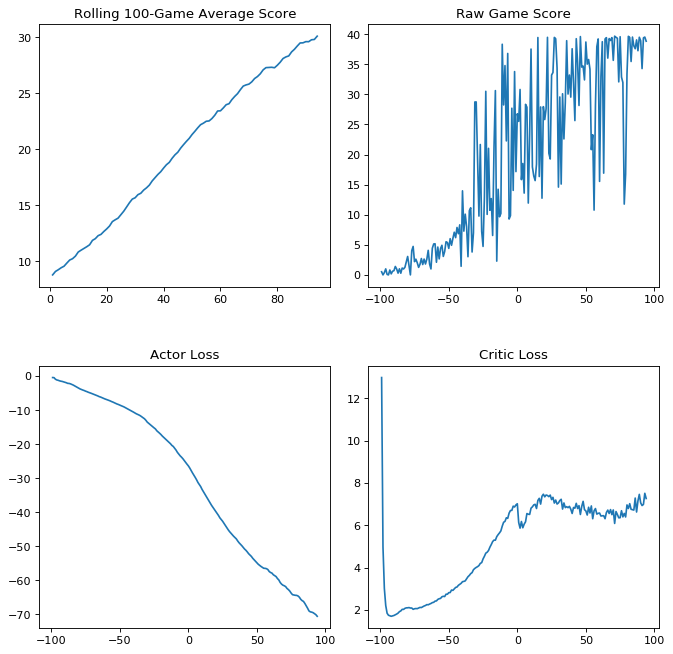

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

#import data
with open('./data/data_episode_metric.pickle', 'rb') as fp:
    episode_metric = pickle.load(fp)
with open('./data/data_rolling_metric.pickle', 'rb') as fp:
    rolling_metric = pickle.load(fp)
with open('./data/data_absolute_metric.pickle', 'rb') as fp:
    absolute_metric = pickle.load(fp)
with open('./data/data_actor_loss_metric.pickle', 'rb') as fp:
    actor_loss = pickle.load(fp)
with open('./data/data_critic_loss_metric.pickle', 'rb') as fp:
    critic_loss = pickle.load(fp)
    
#Create a plot containing the rolling average score, the raw score, the critic loss, and the actor loss
fig = plt.figure(figsize = (10, 10), dpi = 80)
ax1 = plt.subplot2grid((2, 4), (0, 0), rowspan = 1, colspan = 2)
ax2 = plt.subplot2grid((2, 4), (0, 2), rowspan = 1, colspan = 2)
ax3 = plt.subplot2grid((2, 4), (1, 0), rowspan = 1, colspan = 2)
ax4 = plt.subplot2grid((2, 4), (1, 2), rowspan = 1, colspan = 2)
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

average_x = episode_metric[-episode_metric[-1]:]
average_y = rolling_metric[-episode_metric[-1]:]
ax1.plot(average_x, average_y)
ax1.set_title("Rolling 100-Game Average Score", fontsize = 12)

ax2.plot(episode_metric, absolute_metric)
ax2.set_title("Raw Game Score", fontsize = 12)

ax3.plot(episode_metric, actor_loss)
ax3.set_title("Actor Loss", fontsize = 12)

ax4.plot(episode_metric, critic_loss)
ax4.set_title("Critic Loss", fontsize = 12)

## Discussion of results and other ideas for future improvement

The results above are described in this section. There are four graphs, each corresponding to different metrics. In the top left, the rolling 100-game average score is plotted. This plot starts at 0 because it is the first episode where 100 previous episodes were collected to begin collecting an average. In the top right is the raw score associated with each individual episode during training. In the bottom left is the actor loss at every episode (calculated as the average of all actor losses at every time step within that episode). In the bottom right is the critic loss at every episode (calculated as the average of all critic losses at every time step within that episode).  

Overall, learning appears to be very consistent until the environment is solved, and constant improvement is evident from the plots above. The smoothness and efficiency of the learning is a little surprising considering only one agent was used instead of multiple agents working in parallel.  

For future improvement, a goal would be to solve the environment faster. To do this, several changes could be explored. One would be to change the exploration strategy by changing the decay function on the standard deviation of the noise added to the actor. Another possibility would be to add parameter noise directly into the neural network which has been shown to improve exploration in Reinforcement Learning agents (https://arxiv.org/pdf/1706.01905.pdf, https://arxiv.org/pdf/1706.10295.pdf). Another possibility for improving the agent exploration would be to use a curiosity metric: https://arxiv.org/pdf/1705.05363.pdf.  

Another change that could be made would be to implement a parameter search on all of the various hyperparameters. These would include things like the network architectures, batch sizes, gamma, tau, and so on. The parameters used in this project were manually tuned without the use of an extensive/automatic parameter search, so better results almost certainly exist.  

Finally, multiple agents could be utilized to train in parallel which would theoretically speed up learning since more agents are exploring the action space. Theoretically, because more agents are exploring, the solution towards an optimal policy would be found faster.  